In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 1
## Dataset Generation

Write a function to **generate a training set** of size $m$
- randomly generate a weight vector $w \in \mathbb{R}^{10}$, normalize length
- generate a training set $\{(x_i , y_i)\}$ of size m
  - $x_i$: random vector in $\mathbb{R}^{10}$ from $\textbf{N}(0, I)$
  - $y_i$: $\{0, +1\}$ with $P[y = +1] = \sigma(w \cdot x_i)$ and $P[y = 0] = 1 - \sigma(w \cdot x_i)$

In [28]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def GenLabel(x, w_star):
    # dot product of x and w_star
    probability = sigmoid(np.dot(x, w_star))  
    return 1 if np.random.uniform(0, 1) < probability else 0

def generate_data(m):
    w = np.random.randn(10)  
    # Generate the euclidian norm of w_star
    norm_w = np.linalg.norm(w)  
    # Normalize w_star
    w_star_normalized = w / norm_w  

    # generate m random x_i, each x_i is a 10-dimensional vector
    X = np.random.randn(m, 10)
    
    # generate m random y_i, using the function GenLabel
    y = np.array([GenLabel(x_i, w_star_normalized) for x_i in X])
    
    return X, y, w_star_normalized

## Algorithm 1: logistic regression

The goal is to learn $w$.  Algorithm 1 is logistic
  regression (you may use the built-in method LogisticRegression for this. Use max_iter=1000).

In [29]:
from sklearn.linear_model import LogisticRegression

def logistic_regression(X, y):
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    # Get learned weights
    w_learned = model.coef_.ravel()
    return w_learned


## Algorithm 2: gradient descent with square loss

Define square loss as
$$L_i(w^{(t)}) = \frac{1}{2} \left( \sigma(w^{(t)} \cdot x) - y_i \right)^2$$

  Algorithm 2 is
  gradient descent with respect to square loss (code this
  up yourself -- run for 1000 iterations, use step size eta = 0.01).

## Algorithm 3: stochastic gradient descent with square loss
Similar to gradient descent, except we use the gradient at a single random training point every iteration.

In [30]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def square_loss_gradient(X, y, w):
    predictions = sigmoid(np.dot(X, w))
    errors = predictions - y
    gradient = np.dot(X.T, errors * predictions * (1 - predictions))  
    return gradient / len(X)

def gradient_descent(X, y, eta=0.01, iterations=1000):
    w = np.zeros(X.shape[1])
    for _ in range(iterations):
        gradient = square_loss_gradient(X, y, w)
        w -= eta * gradient
    return w

def stochastic_gradient_descent(X, y, eta=0.01, iterations=1000):
    w = np.zeros(X.shape[1])
    for _ in range(iterations):
        i = np.random.randint(0, len(X))
        gradient = square_loss_gradient(X[i:i+1], y[i:i+1], w)
        w -= eta * gradient
    return w


## Evaluation

Measure error $\|w - \hat{w}\|_2$ for each method at different sample size. For any
  fixed value of $m$, choose many different $w$'s and average the
  values $\|w - 
  \hat{w}\|_2$ for Algorithms 1, 2 and 3.  Plot the results
  for for each algorithm as you make $m$ large (use $m=50, 100, 150, 200, 250$).
  Also record, for each algorithm, the time taken to run the overall experiment.

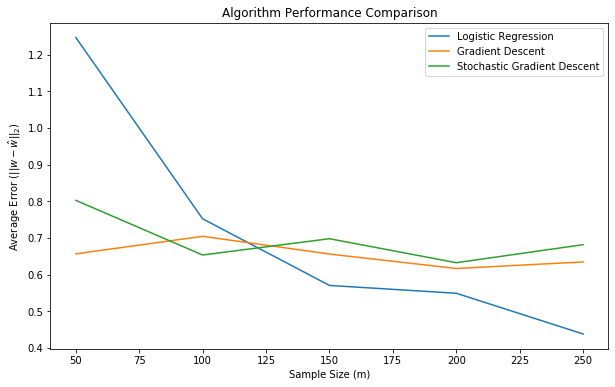

Logistic Regression Time: 0.10645270347595215
Gradient Descent Time: 0.7235410213470459
Stochastic Gradient Descent Time: 0.8012690544128418


In [32]:
import matplotlib.pyplot as plt
import time

def evaluate_algorithm(m_values, algorithm, generate_data_func):
    errors = []
    times = []
    for m in m_values:
        start_time = time.time()
        total_error = 0
        for _ in range(10):  # Do 10 times to get average error
            X, y, w_star = generate_data_func(m)
            w_hat = algorithm(X, y)
            total_error += np.linalg.norm(w_star - w_hat)
        average_error = total_error / 10
        errors.append(average_error)
        times.append(time.time() - start_time)
    return errors, times

m_values = [50, 100, 150, 200, 250]

errors_lr, times_lr = evaluate_algorithm(m_values, logistic_regression, generate_data)
errors_gd, times_gd = evaluate_algorithm(m_values, gradient_descent, generate_data)
errors_sgd, times_sgd = evaluate_algorithm(m_values, stochastic_gradient_descent, generate_data)

# plots
plt.figure(figsize=(10, 6))
plt.plot(m_values, errors_lr, label='Logistic Regression')
plt.plot(m_values, errors_gd, label='Gradient Descent')
plt.plot(m_values, errors_sgd, label='Stochastic Gradient Descent')
plt.xlabel('Sample Size (m)')
plt.ylabel('Average Error ($||w - \hat{w}||_2$)')
plt.title('Algorithm Performance Comparison')
plt.legend()
plt.show()

print("Logistic Regression Time:", np.sum(times_lr))
print("Gradient Descent Time:", np.sum(times_gd))
print("Stochastic Gradient Descent Time:", np.sum(times_sgd))


# Problem 2

In [33]:
from sklearn import datasets

In [34]:
cancer = datasets.load_breast_cancer()

For each depth in $1, \dots, 5$, instantiate an AdaBoost classifier with the base learner set to be a decision tree of that depth (set `n_estimators=10` and `learning_rate=1`), and then record the 10-fold cross-validated error on the entire breast cancer data set. Plot the resulting curve of accuracy against base classifier depth. Use $101$ as your random state for both the base learner as well as the AdaBoost classifier every time.

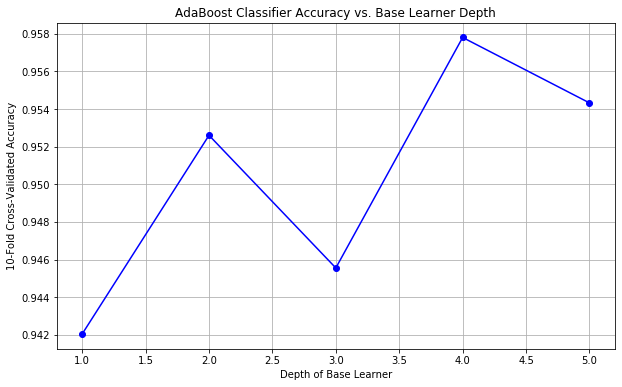

In [35]:
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

depths = range(1, 6)
accuracies = []
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)

for depth in depths:
    base_learner = DecisionTreeClassifier(max_depth=depth, random_state=101)
    
    ada_clf = AdaBoostClassifier(base_estimator=base_learner, n_estimators=10, learning_rate=1, random_state=101)
    
    scores = cross_val_score(ada_clf, X, y, cv=cv)
    accuracies.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, marker='o', linestyle='-', color='b')
plt.title('AdaBoost Classifier Accuracy vs. Base Learner Depth')
plt.xlabel('Depth of Base Learner')
plt.ylabel('10-Fold Cross-Validated Accuracy')
plt.grid(True)
plt.show()
